In [1]:
import numpy as np
import math
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from financepy.models.black import *
from financepy.utils.global_types import *
import Fourier as fourier

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [2]:
def blackImpliedVol(forward,   # Forward rate F
                    K,         # Strike Rate K
                    T,         # Time to Expiry (years)
                    DF,        # df RFR to expiry date
                    callOrPut, # FinOptionTypes.EUROPEAN_CALL or FinOptionTypes.EUROPEAN_PUT
                    price
                    ):    
    min_ivol, max_ivol = 0.001, 1.0
    f = lambda ivol: Black(ivol).value(forward, K, T, DF, callOrPut) - price    
    return optimize.bisect(f, min_ivol, max_ivol)    

def blackVega(forward, K, T, DF, ivol, callOrPut):
    return Black(ivol).vega(forward, K, T, DF, callOrPut)

### Dataset 1

<Axes: xlabel='Strike'>

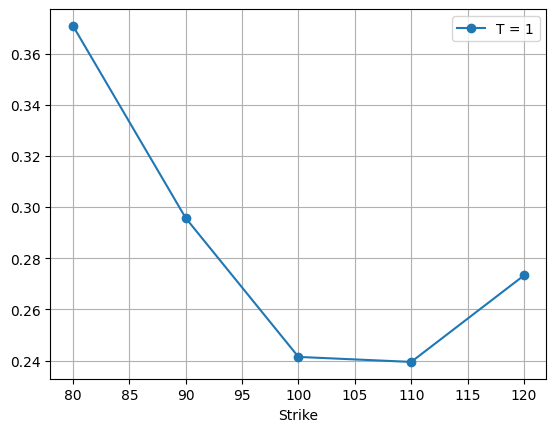

In [3]:
S0 = 100
Ts = [1]
rs = [0]
callOrPut = OptionTypes.EUROPEAN_CALL
Ks = [80, 90, 100, 110, 120]
call_option_prices = {'Strike': Ks, 
                      'T = ' + str(Ts[0]): [25.52631937139183, 16.86141804446963, 9.608152791141933, 5.7851214155396065, 4.495915675832514]}

df_call_option_prices = pd.DataFrame(call_option_prices)
df_call_option_prices = df_call_option_prices.set_index('Strike')

### Find the implied vol from call option prices, ease for checking calibration error
df_mkt_ivols = pd.DataFrame()
df_mkt_ivols['Strike'] = Ks

df_vegas_w = pd.DataFrame()
df_vegas_w['Strike'] = Ks  

for r, T in zip(rs, Ts):    
    DF = np.exp(-r*T)
    forward = S0 * np.exp(r*T)
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, df_call_option_prices['T = ' + str(T)].loc[K]) for K in Ks]     
    df_mkt_ivols['T = ' + str(T)] = np.array(ivols)    
       
    vegas = [blackVega(forward, K, T, DF, v, callOrPut) for v, K in zip(ivols, Ks)]   
    df_vegas_w['T = ' + str(T)] = np.array(vegas)/np.sqrt(T)

df_mkt_ivols = df_mkt_ivols.set_index('Strike')
df_vegas_w = df_vegas_w.set_index('Strike')

df_mkt_ivols.plot(grid='True', style='o-')


### Heston and MJD calibration objective function

In [4]:
#input: 
#   var_0 = params[0]
#   mean_rev_speed = params[1]
#   mean_rev_level = params[2]
#   vol_of_var = params[3]
#   corr = params[4]    
#   calib_type
#output: list of residuals
def heston_obj_func(S0, Ks, Ts, rs, mkt_call_data, params, vega_data):  
    vol_0 = np.sqrt(params[0])    
    residuals = []
    for r, T in zip(rs, Ts):    
        DF = np.exp(-r*T)
        forward = S0 * np.exp(r*T)
        mdl_prices = [DF * fourier.carr_madan_heston_call_option(forward, vol_0, params[1], params[2], params[3], params[4], T, K) for K in Ks]      
        mkt_prices = list(mkt_call_data['T = ' + str(T)])
        vegas = list(vega_data['T = ' + str(T)])
        res = [vega*(mdl/mkt-1.0)**2 for mdl, mkt, vega in zip(mdl_prices, mkt_prices, vegas)]                
        residuals.extend(res)     
        
    return residuals

def unpack_heston_calib_params(heston_calib_res):
    var_0 = heston_calib_res.x[0]    
    mean_rev_speed = heston_calib_res.x[1]
    mean_rev_level = heston_calib_res.x[2]
    vol_of_var = heston_calib_res.x[3]
    corr = heston_calib_res.x[4]   
    return var_0, mean_rev_speed, mean_rev_level, vol_of_var, corr

#initial values
var_0, mean_rev_speed, mean_rev_level, vol_of_var, corr = 0.1, 1, 0.5, 0.8, -0.5   
init_param_heston = np.array([var_0, mean_rev_speed, mean_rev_level, vol_of_var, corr])

#input: 
#   vol = params[0]
#   a = params[1]
#   b = params[2]
#   lam = params[3]  
#output: list of residuals
def MJD_obj_func(S0, Ks, Ts, rs, mkt_call_data, params, vega_data):     
    residuals = []
    for r, T in zip(rs, Ts):    
        DF = np.exp(-r*T)
        forward = S0 * np.exp(r*T)
        mdl_prices = [DF * fourier.carr_madan_MJD_call_option(forward, params[0], params[1], params[2], params[3], T, K) for K in Ks]      
        mkt_prices = list(mkt_call_data['T = ' + str(T)])
        vegas = list(vega_data['T = ' + str(T)])
        res = [vega*(mdl/mkt-1.0)**2 for mdl, mkt, vega in zip(mdl_prices, mkt_prices, vegas)]  
        residuals.extend(res)     
        
    return residuals

def unpack_MJD_calib_params(MJD_calib_res):
    vol = MJD_calib_res.x[0]    
    a = MJD_calib_res.x[1]
    b = MJD_calib_res.x[2]
    lam = MJD_calib_res.x[3]
    return vol, a, b, lam

#initial values
vol = 0.2; a = -0.5; b = 1.44; lam = 0.12
init_param_MJD = np.array([vol, a, b, lam])

#[ 0.26830666 -1.344381    1.4427396   0.11208649]

### Perform Heston Calibration 

In [5]:
df_vegas_w.loc[100] = 70

print(df_vegas_w)

            T = 1
Strike           
80      29.265041
90      35.132997
100     70.000000
110     38.379186
120     34.655785


In [6]:
# for all maturities


obj_function = lambda p: heston_obj_func(S0, Ks, Ts, rs, df_call_option_prices, p, df_vegas_w)
heston_weighted_calib_res_price = optimize.least_squares(obj_function, init_param_heston, method='lm', xtol=1E-8)
print(heston_weighted_calib_res_price.x)

#Strike          
#80      0.027760
#90      0.010326
#100    -0.001601
#110    -0.004020
#120     0.003341

[ 0.29227034  0.26867275 -0.13541214  2.92873231 -0.33252678]


In [7]:
# for all maturities
df_vegas_w.loc[:,:] = 1

obj_function = lambda p: heston_obj_func(S0, Ks, Ts, rs, df_call_option_prices, p, df_vegas_w)
heston_calib_res_price = optimize.least_squares(obj_function, init_param_heston, method='lm', xtol=1E-8)
print(heston_calib_res_price.x)

# Strike          
# 80      0.027384
# 90      0.009783
# 100    -0.002244
# 110    -0.004331
# 120     0.003350

[ 0.29328793  0.23837762 -0.15393029  2.95184996 -0.33522283]


### Check the calibration result

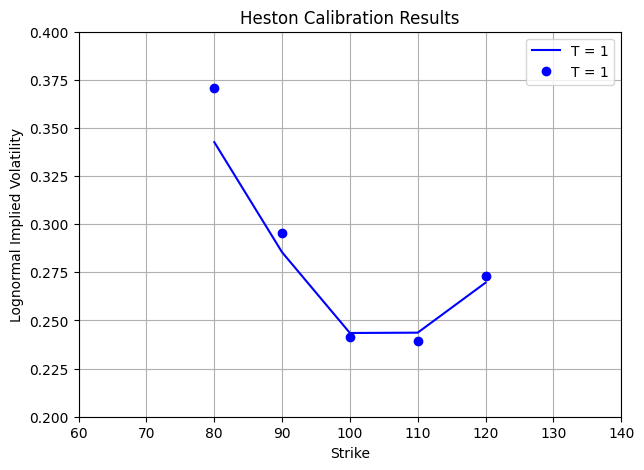

           T = 1
Strike          
80      0.028152
90      0.010259
100    -0.002076
110    -0.004197
120     0.003626


In [8]:
var_0, mean_rev_speed, mean_rev_level, vol_of_var, corr = unpack_heston_calib_params(heston_weighted_calib_res_price)
vol_0 = np.sqrt(var_0)
K1s = np.linspace(60, 140, 31)
K1s = Ks
df_heston_calibrated = pd.DataFrame()
df_heston_calibrated['Strike'] = K1s

for r, T in zip(rs, Ts):    
    DF = np.exp(-r*T)
    forward = S0 * np.exp(r*T)
    call_values = [DF * fourier.carr_madan_heston_call_option(forward, vol_0, mean_rev_speed, mean_rev_level, vol_of_var, corr, T, K) for K in K1s]      
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(call_values, K1s)]       
    df_heston_calibrated['T = ' + str(T)] = np.array(ivols)

df_heston_calibrated = df_heston_calibrated.set_index('Strike')

#---------------------------------------------------------------------
ax = df_heston_calibrated.plot(grid=True, figsize=(7, 5), color = ['blue','orange','green'])
df_mkt_ivols.plot(ax=ax, grid=True, figsize=(7, 5), style='o', color = ['blue','orange','green'])

plt.title("Heston Calibration Results")
plt.xlim(60, 140)
plt.ylim(0.2, 0.4)
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")
#plt.savefig("L4_heston_calib.png")

plt.show()

print(df_mkt_ivols - df_heston_calibrated)

### Perform MJD calibration

In [9]:
#initial values 
obj_function = lambda p: MJD_obj_func(S0, Ks, Ts, rs, df_call_option_prices, p, df_vegas_w)
MJD_calib_res_price = optimize.least_squares(obj_function, init_param_MJD, method='lm', xtol=1E-4 )
print(MJD_calib_res_price.x)

[ 0.08834143 -0.89131582  1.15795878  0.16788404]


Text(0, 0.5, 'Lognormal Implied Volatility')

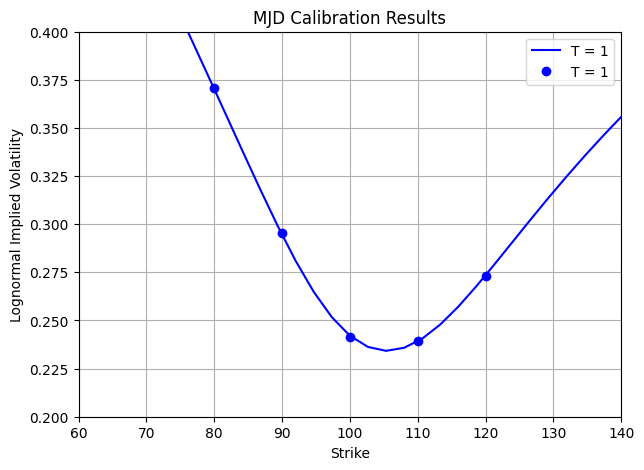

In [10]:
vol, a, b, lam = unpack_MJD_calib_params(MJD_calib_res_price)
K1s = np.linspace(60, 140, 31)
df_MJD_calibrated = pd.DataFrame()
df_MJD_calibrated['Strike'] = K1s

for r, T in zip(rs, Ts):    
    DF = np.exp(-r*T)
    forward = S0 * np.exp(r*T)
    call_values = [DF * fourier.carr_madan_MJD_call_option(forward, vol, a, b, lam, T, K) for K in K1s]      
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(call_values, K1s)]       
    df_MJD_calibrated['T = ' + str(T)] = np.array(ivols)

df_MJD_calibrated = df_MJD_calibrated.set_index('Strike')

#---------------------------------------------------------------------
ax = df_MJD_calibrated.plot(grid=True, figsize=(7, 5), color = ['blue','orange','green'])
df_mkt_ivols.plot(ax=ax, grid=True, figsize=(7, 5), style='o', color = ['blue','orange','green'])

plt.title("MJD Calibration Results")
plt.xlim(60, 140)
plt.ylim(0.2, 0.4)
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")
#plt.savefig("L4_MJD_calib.png")

In [11]:
def generate_option_prices():
    S0 = 100
    Ks = [ 40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160,]
    ivols = [0.5645, 0.4800, 0.4089, 0.3467, 0.2913, 0.2421, 0.2018, 0.1800, 0.1811, 0.1941, 0.2104, 0.2269, 0.2428]
    ivols = [0.30000006, 0.29999997, 0.29999994, 0.29999994, 0.29999996,
       0.3       , 0.30000005, 0.3000001 , 0.30000016, 0.30000022,
       0.30000028, 0.30000034, 0.30000041]
    r = 0
    T = 1
    forward = S0
    DF = np.exp(-r*T)

    prices = [Black(ivol).value(forward, K, T, DF, callOrPut) for K, ivol in zip(Ks, ivols)]

    rounded_prices = [round(p, 2) for p in prices]


    check_ivol = [blackImpliedVol(forward, K, T, DF, callOrPut, price)  for K, price in zip(Ks, rounded_prices)]
    print(rounded_prices)
    print(Ks)
    print(check_ivol)

In [12]:
generate_option_prices()

[60.01, 50.07, 40.42, 31.43, 23.53, 17.01, 11.92, 8.14, 5.44, 3.57, 2.32, 1.49, 0.95]
[40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
[0.31401848374590735, 0.29755338548047616, 0.3001974327100051, 0.30002288651015807, 0.2998359188311533, 0.29991807105944274, 0.2999102000003313, 0.2999743142718561, 0.2999840294209443, 0.29987007984320907, 0.3001446248037445, 0.3002116088888924, 0.3002852521403966]
